# CSE253 PA3 - Simplicity All-CNN
With a simple 5-layer CNN, we achieved up to 87% validation accuracy, 83% test accuracy and ensemble test accuracy of 87%.

We decide to improve on this by following the general direction proposed by "Strive for Simplicity":

https://arxiv.org/abs/1412.6806

The general idea is that an all-CNN network can equal or outperform current state-of-the-art CNNs by:

1. Replace maxpool layer with a convolutional layer of stride=2
2. The linear layer can be replaced with a "network-in-network" structure

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.4


In [102]:
import torchvision.transforms as transforms

class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 48000
NUM_VAL = 2000
NUM_TRAIN_SMALL=1000

# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.RandomResizedCrop(32),  # data augmentation - random crop
    transforms.RandomHorizontalFlip(),      # data augmentation - horizontal flip
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train=True, download=True,
                           transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_train_small = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN_SMALL, 0))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, 
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, 
                          transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
cpu_dtype = torch.FloatTensor # the CPU datatype
gpu_dtype = torch.cuda.FloatTensor

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()
        
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

Size of CFAR10 Train Set:  50000
torch.Size([64, 3, 32, 32])
 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer plane plane truck   car   cat  deer plane   cat horse   cat   cat   dog  bird  bird horse   car   car   car  bird  bird plane truck   dog horse truck  bird  bird   dog  bird  deer   cat   car   car  ship  bird


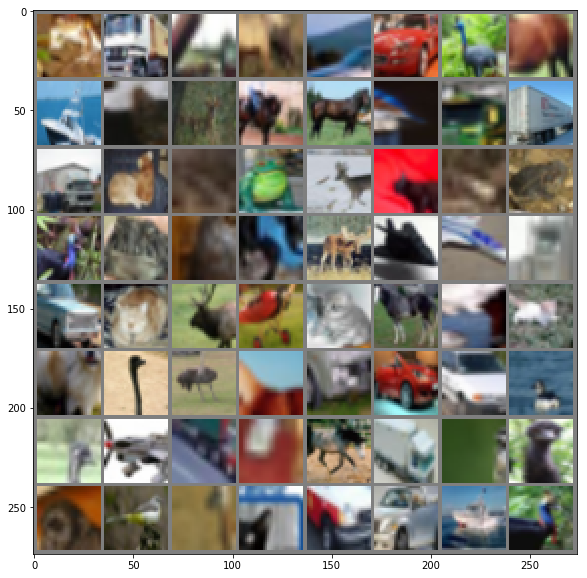

In [104]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

print ("Size of CFAR10 Train Set: ", len(cifar10_train))
    
# get some random training images
dataiter = iter(loader_train)
images, labels = dataiter.next()

print (images.size())

# show images
plt.figure(figsize=(10,10))
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))

In [98]:
def train_simple(model, loss_fn, optimizer, num_epochs = 10, verbose=False):
    # Train the model - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch

    scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 every 5 epochs 
    # scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)
       
        if verbose:
            print("epoch {}/{}: train acc={:.3f}, val acc={:.3f}, loss={:.8f}".format(epoch + 1, \
                                        num_epochs, train_acc,val_acc,train_lossSum/train_total))
        train_history.append([train_acc,val_acc,train_lossSum/train_total])
        
    return train_history 


def train_detailed(model, loss_fn, optimizer, filename, num_epochs = 10, verbose=False):
    # Train the model in greater detail - output validation and train accuracy every epoch
    
    train_history = []   # this will store train accuracy, val accuracy and loss for every epoch
    best_val_acc = 0.0  # initialize best_val_acc

    # scheduler = StepLR(optimizer, step_size=5, gamma=0.9)   # decay lr by 0.9 very 5 epochs 
    scheduler = StepLR(optimizer, step_size=1, gamma=0.95)   # decay lr by 0.95 every epoch 
    
    for epoch in range(num_epochs):        
        
        scheduler.step()    
        model.train()
        
        train_lossSum = 0 
        train_total = 0
        for t, (x, y) in enumerate(loader_train):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            train_total += y_var.size(0)

            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            train_lossSum += loss.data[0]  # Accumulate loss over epoch
            
            if (t + 1) % print_every == 0 and verbose:
                print('t = %d, loss = %.6f' % (t + 1, loss.data[0]))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
       
        # We calculate validation and training accuracy at the end of every epoch
        val_acc = check_accuracy(model, loader_val) 
        train_acc = check_accuracy(model, loader_train_small)

        # Compute validation loss    
        val_lossSum = 0.0
        val_total = 0
        for t, (x, y) in enumerate(loader_val):
            x_var = Variable(x.type(gpu_dtype))
            y_var = Variable(y.type(gpu_dtype).long())
            val_total += y_var.size(0)
            
            scores = model(x_var)
            loss = loss_fn(scores, y_var)
            val_lossSum += loss.data[0]
        
        if val_acc > best_val_acc:  
            # save your model
            if verbose:
                print ("better val accuracy: update model.")
            torch.save(model.state_dict(), filename)
            best_val_acc = val_acc 

        if verbose:
            print("epoch {}/{}: train acc={:.3f}, val acc={:.3f}, train loss={:.8f}, val loss ={:.8f}". \
                  format(epoch + 1, num_epochs, train_acc,val_acc,train_lossSum/train_total, val_lossSum/val_total))
    
        train_history.append([train_acc,val_acc,train_lossSum/train_total,val_lossSum/val_total])
        
    return best_val_acc, train_history 
        

def check_accuracy(model, loader, verbose=False, dtype=gpu_dtype):
    if verbose:
        if loader.dataset.train:
            print('Checking accuracy on validation set')
        else:
            print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    for x, y in loader:
        x_var = Variable(x.type(dtype), volatile=True)

        scores = model(x_var)
        _, preds = scores.data.cpu().max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    if verbose:
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc


## Network Architecture Design



In [93]:
"""
def generator():

    # Model2 - Original Simple 5 layer Conv Layers

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(8192,512),  # 5408=128*16*16 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10),
                    )
    
    
    return model  


def generator():

    # Model2a - 5 layer Conv Layers with average pooling

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        

                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(128,10),
                    )
    
    
    return model 


def generator_m31():

    # Model3-1 - 7 layer Conv Layers with average pooling, replace both maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=512),        
                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(512,10),
                    )
    return model 

def generator_m32():

    # Model3-2 - 6 layer Conv Layers with average pooling, replace 1 maxpool with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half         
                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(256,10),
                    )
    return model


def generator_m33():

    # Model3-3 - Wider 6 layer Conv Layers with average pooling, replace 1 maxpool with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half         
                    nn.AvgPool2d(8),
                    Flatten(),
                    nn.Linear(256,10),
                    )
    return model
"""

def generator_m34():

    # Model3-4 - 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half        
                    Flatten(),
                    nn.Linear(16384,512),  # 16384=256*8*8 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10)
                    )
    return model

def generator_m35():

    # Model3-5 - Wide 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.MaxPool2d(kernel_size=2,stride=2),  # Downsample by half      
                    Flatten(),
                    nn.Linear(16384,512),  # 16384=256*8*8 input size
                    nn.BatchNorm1d(512),
                    nn.ReLU(inplace=True),
                    nn.Linear(512,10)
                    )
    return model


def generator_m36():

    # Model3-6 - 10 layer Conv Layers - replace 1st maxpools with conv(stride=2), replace Maxpool-Linear 
    # with 3-layer "network-in-network"

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256) ,       
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),        
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=10,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=10),        
                    nn.AvgPool2d(10),       
                    Flatten()
                    )
    return model

def generator_m37():

    # Model3-7 - 9 layer Conv Layers - replace 1st maxpools with conv(stride=2), replace Maxpool-Linear 
    # with 3-layer "network-in-network"

    model = nn.Sequential(
                    nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=32),
                    nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=64,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=64),
                    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=2,padding=1), # 2:1 downsample
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),        
                    nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=128),
                    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,stride=2,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),        
                    nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=256),
                    nn.Conv2d(in_channels=256,out_channels=10,kernel_size=1,stride=1,padding=1), # preserve dimension
                    nn.ReLU(inplace=True),
                    nn.BatchNorm2d(num_features=10),        
                    nn.AvgPool2d(10),       
                    Flatten()
                    )
    return model

### Dimension Check

Handy to check dimension when putting together a CNN architecture

In [94]:
generators = [generator_m34, generator_m35, generator_m36]

for generator in generators:
    model = generator().type(gpu_dtype)
    print (model)
    
    x_gpu = torch.randn(64, 3, 32, 32).type(gpu_dtype)
    x_var_gpu = Variable(x_gpu.type(gpu_dtype)) # Construct a PyTorch Variable out of your input data
    ans = model(x_var_gpu)        # Feed it through the model! 

    print (ans.shape)

    # Check to make sure what comes out of your model
    # is the right dimensionality... this should be True
    # if you've done everything correctly
    print (np.array_equal(np.array(ans.size()), np.array([64, 10])))

Sequential(
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (9): Conv2d (64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU(inplace)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace)
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (18): MaxPool2d(kernel_size=(2, 2),

### Coarse Accessment - AvgPool+MaxPool Removal vs Original Simple 5-Layer Net

None of the models that replace the linear layer with average pooling AND replacing maxpooling with conv(stride=2) has better validation accuracy than the original simple 5-layer CNN.

In [45]:
epochs = 3

generators = [generator_m31,generator_m32,generator_m33]

for generator in generators:
    print (generator())
    stat = []
    
    start = time.time()
    max_count = 20
    for count in range(max_count):
        reg = 1e-10
        lr = 10**random.uniform(-5,-2)
        
        model = generator().type(gpu_dtype)
    
        loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
        train_simple(model, loss_fn, optimizer, num_epochs=epochs)
        val_acc = check_accuracy(model, loader_val)
    
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
        stat.append([lr, reg, val_acc])

    end = time.time()
    
    print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

    sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
    print ("In descending order of learning rate:")
    for lr, reg, val_acc in sorted_stat:
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc)) 

Sequential(
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (9): Conv2d (64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU(inplace)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace)
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (18): Conv2d (256, 512, kernel_size

lr = 1.87569e-05, reg = 1.00000e-10, validation accuracy is 0.54800000  
lr = 2.77046e-05, reg = 1.00000e-10, validation accuracy is 0.55300000  
lr = 1.45329e-03, reg = 1.00000e-10, validation accuracy is 0.77300000  
lr = 9.39595e-04, reg = 1.00000e-10, validation accuracy is 0.79200000  
lr = 6.41832e-04, reg = 1.00000e-10, validation accuracy is 0.77500000  
lr = 6.73909e-04, reg = 1.00000e-10, validation accuracy is 0.78300000  
lr = 1.34751e-05, reg = 1.00000e-10, validation accuracy is 0.54300000  
lr = 8.43238e-04, reg = 1.00000e-10, validation accuracy is 0.78500000  
lr = 1.83532e-04, reg = 1.00000e-10, validation accuracy is 0.75100000  
lr = 4.90320e-03, reg = 1.00000e-10, validation accuracy is 0.72000000  
lr = 4.46550e-03, reg = 1.00000e-10, validation accuracy is 0.73200000  
lr = 8.43871e-05, reg = 1.00000e-10, validation accuracy is 0.68200000  
lr = 4.96855e-05, reg = 1.00000e-10, validation accuracy is 0.63000000  
lr = 6.69467e-05, reg = 1.00000e-10, validation acc

In [65]:
epochs = 3

generators = [generator_m34, generator_m35]

for generator in generators:
    print (generator())
    stat = []
    
    start = time.time()
    max_count = 20
    for count in range(max_count):
        reg = 1e-10
        lr = 10**random.uniform(-5,-2)
        
        model = generator().type(gpu_dtype)
    
        loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
        train_simple(model, loss_fn, optimizer, num_epochs=epochs)
        val_acc = check_accuracy(model, loader_val)
    
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
        stat.append([lr, reg, val_acc])

    end = time.time()
    
    print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

    sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
    print ("In descending order of learning rate:")
    for lr, reg, val_acc in sorted_stat:
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc)) 

Sequential(
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (9): Conv2d (64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU(inplace)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace)
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (18): MaxPool2d(kernel_size=(2, 2),

In [95]:
epochs = 3

generators = [generator_m36,generator_m37]

for generator in generators:
    print (generator())
    stat = []
    
    start = time.time()
    max_count = 20
    for count in range(max_count):
        reg = 1e-10
        lr = 10**random.uniform(-5,-2)
        
        model = generator().type(gpu_dtype)
    
        loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
        train_simple(model, loss_fn, optimizer, num_epochs=epochs)
        val_acc = check_accuracy(model, loader_val)
    
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
        stat.append([lr, reg, val_acc])

    end = time.time()
    
    print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

    sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
    print ("In descending order of learning rate:")
    for lr, reg, val_acc in sorted_stat:
        print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))

Sequential(
  (0): Conv2d (3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (3): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU(inplace)
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (6): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace)
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (9): Conv2d (64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): ReLU(inplace)
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (15): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU(inplace)
  (17): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (18): Conv2d (256, 256, kernel_size

## Architecture Evaluation - Finding 1

** In Step 1, we discover that average pooling can reduce CNN performance. **

Average pooling substantially reduces the number of parameters in a CNN. But based on training many permutations of CNN utilizing ** ONLY ** average pooling, none seems to match the validation accuracy achieved by the simple 5-Layer CNN utilizing fully connected layers.

Baseline for the Simple 5-Layer CNN: Val Accuracy up to 82%; 8sec train time/epoch  

lr = 7.51469e-03, reg = 1.00000e-10, validation accuracy is 0.75700000  
lr = 5.14072e-03, reg = 1.00000e-10, validation accuracy is 0.79800000  
lr = 4.20077e-03, reg = 1.00000e-10, validation accuracy is 0.80300000  
lr = 3.50547e-03, reg = 1.00000e-10, validation accuracy is 0.77000000  
lr = 2.75853e-03, reg = 1.00000e-10, validation accuracy is 0.78100000  
** lr = 2.06305e-03, reg = 1.00000e-10, validation accuracy is 0.80700000 **    
** lr = 1.71008e-03, reg = 1.00000e-10, validation accuracy is 0.81100000 **  
** lr = 1.38126e-03, reg = 1.00000e-10, validation accuracy is 0.81500000 **  
** lr = 1.29855e-03, reg = 1.00000e-10, validation accuracy is 0.80800000 **  
** lr = 1.28852e-03, reg = 1.00000e-10, validation accuracy is 0.80600000 **  
** lr = 7.57126e-04, reg = 1.00000e-10, validation accuracy is 0.81400000 **  
** lr = 6.09412e-04, reg = 1.00000e-10, validation accuracy is 0.82300000 **  
lr = 2.41346e-04, reg = 1.00000e-10, validation accuracy is 0.78000000  
lr = 2.39668e-04, reg = 1.00000e-10, validation accuracy is 0.79300000  
lr = 2.10252e-04, reg = 1.00000e-10, validation accuracy is 0.79200000  
lr = 2.09760e-04, reg = 1.00000e-10, validation accuracy is 0.77000000  
lr = 2.08300e-04, reg = 1.00000e-10, validation accuracy is 0.77500000  
lr = 4.15121e-05, reg = 1.00000e-10, validation accuracy is 0.70000000  
lr = 3.90442e-05, reg = 1.00000e-10, validation accuracy is 0.69200000  
lr = 1.34430e-05, reg = 1.00000e-10, validation accuracy is 0.65000000   

Training time per epochs: 8.0 sec 

### AvgPool 5-layer model (Less Accurate and Faster)
* Model2a - 5 layer Conv Layers with average pooling replacing the fully connected layer before Softmax
* Val Accuracy up to 78%; 7sec train time/epoch  

lr = 9.88064e-03, reg = 1.00000e-10, validation accuracy is 0.74100000  
lr = 7.24209e-03, reg = 1.00000e-10, validation accuracy is 0.71000000  
lr = 5.59050e-03, reg = 1.00000e-10, validation accuracy is 0.73700000  
** lr = 3.94273e-03, reg = 1.00000e-10, validation accuracy is 0.77600000 **  
** lr = 3.64597e-03, reg = 1.00000e-10, validation accuracy is 0.76100000 **  
** lr = 3.18349e-03, reg = 1.00000e-10, validation accuracy is 0.76900000 **  
** lr = 2.60574e-03, reg = 1.00000e-10, validation accuracy is 0.77700000 **  
** lr = 2.12727e-03, reg = 1.00000e-10, validation accuracy is 0.78000000 **    
** lr = 1.20893e-03, reg = 1.00000e-10, validation accuracy is 0.76500000 **   
** lr = 1.05877e-03, reg = 1.00000e-10, validation accuracy is 0.75100000 **  
** lr = 9.68687e-04, reg = 1.00000e-10, validation accuracy is 0.76600000 **  
** lr = 6.80745e-04, reg = 1.00000e-10, validation accuracy is 0.77200000 **  
** lr = 5.53122e-04, reg = 1.00000e-10, validation accuracy is 0.75000000 **  
lr = 2.28815e-04, reg = 1.00000e-10, validation accuracy is 0.71900000  
lr = 1.03441e-04, reg = 1.00000e-10, validation accuracy is 0.64000000  
lr = 9.72731e-05, reg = 1.00000e-10, validation accuracy is 0.63200000  
lr = 6.17974e-05, reg = 1.00000e-10, validation accuracy is 0.62000000  
lr = 3.54411e-05, reg = 1.00000e-10, validation accuracy is 0.55100000  
lr = 3.53624e-05, reg = 1.00000e-10, validation accuracy is 0.54300000  
lr = 2.52510e-05, reg = 1.00000e-10, validation accuracy is 0.52500000   

Training time per epochs: 6.95 sec

### AvgPool 7-layer model (Less Accurate and Slow)
* Model3-1 - 7 layer Conv Layers with average pooling, replace both maxpools with conv(stride=2)  
* Val Accuracy up to 78%; 13sec train time/epoch   

lr = 7.09115e-03, reg = 1.00000e-10, validation accuracy is 0.73700000  
lr = 6.57948e-03, reg = 1.00000e-10, validation accuracy is 0.73700000  
lr = 3.22029e-03, reg = 1.00000e-10, validation accuracy is 0.74700000  
lr = 3.19221e-03, reg = 1.00000e-10, validation accuracy is 0.75500000  
lr = 2.98689e-03, reg = 1.00000e-10, validation accuracy is 0.74300000  
lr = 2.91777e-03, reg = 1.00000e-10, validation accuracy is 0.74400000  
lr = 2.15298e-03, reg = 1.00000e-10, validation accuracy is 0.72600000  
** lr = 6.68621e-04, reg = 1.00000e-10, validation accuracy is 0.78700000 **  
** lr = 3.55295e-04, reg = 1.00000e-10, validation accuracy is 0.78000000 **  
lr = 2.85458e-04, reg = 1.00000e-10, validation accuracy is 0.76700000  
lr = 1.86754e-04, reg = 1.00000e-10, validation accuracy is 0.73400000  
lr = 9.61003e-05, reg = 1.00000e-10, validation accuracy is 0.68800000  
lr = 8.95098e-05, reg = 1.00000e-10, validation accuracy is 0.68700000  
lr = 6.67966e-05, reg = 1.00000e-10, validation accuracy is 0.65000000  
lr = 2.69343e-05, reg = 1.00000e-10, validation accuracy is 0.55500000  
lr = 2.68940e-05, reg = 1.00000e-10, validation accuracy is 0.57000000  
lr = 2.02110e-05, reg = 1.00000e-10, validation accuracy is 0.57300000  
lr = 1.93037e-05, reg = 1.00000e-10, validation accuracy is 0.55600000  
lr = 1.56585e-05, reg = 1.00000e-10, validation accuracy is 0.52400000  
lr = 1.53503e-05, reg = 1.00000e-10, validation accuracy is 0.54300000  

Training time per epochs: 12.71 sec

### AvgPool 6-layer model (Less Accurate and Slow)
* Model3-2 - 6 layer Conv Layers with average pooling, replace 1st maxpools with conv(stride=2)  
* Val Accuracy up to 76%; 9sec train time/epoch   

lr = 1.52006e-05, reg = 1.00000e-10, validation accuracy is 0.52200000  
lr = 1.19141e-04, reg = 1.00000e-10, validation accuracy is 0.67000000  
** lr = 3.25415e-04, reg = 1.00000e-10, validation accuracy is 0.75700000 **   
lr = 8.97500e-03, reg = 1.00000e-10, validation accuracy is 0.70600000  
lr = 2.98199e-05, reg = 1.00000e-10, validation accuracy is 0.53800000  
lr = 4.04487e-05, reg = 1.00000e-10, validation accuracy is 0.56300000  
lr = 1.78086e-05, reg = 1.00000e-10, validation accuracy is 0.52400000  
lr = 1.61785e-05, reg = 1.00000e-10, validation accuracy is 0.52600000  
lr = 9.93702e-05, reg = 1.00000e-10, validation accuracy is 0.67100000  
lr = 2.76393e-05, reg = 1.00000e-10, validation accuracy is 0.55100000  
lr = 2.25566e-04, reg = 1.00000e-10, validation accuracy is 0.72700000  
lr = 1.82693e-05, reg = 1.00000e-10, validation accuracy is 0.53100000  
lr = 2.73636e-04, reg = 1.00000e-10, validation accuracy is 0.74500000  
lr = 4.01242e-03, reg = 1.00000e-10, validation accuracy is 0.74100000  
lr = 8.13708e-03, reg = 1.00000e-10, validation accuracy is 0.72000000  
lr = 1.54292e-05, reg = 1.00000e-10, validation accuracy is 0.50600000  
** lr = 1.44013e-03, reg = 1.00000e-10, validation accuracy is 0.76200000 **    
** lr = 1.81143e-03, reg = 1.00000e-10, validation accuracy is 0.75900000 **  
lr = 2.18088e-05, reg = 1.00000e-10, validation accuracy is 0.53900000  
lr = 8.50300e-05, reg = 1.00000e-10, validation accuracy is 0.64000000  

Training time per epochs: 9.30 sec

### AvgPool 6-layer model (Less Accurate and Slow)
* Model3-3 - wider 6 layer Conv Layers with average pooling, replace 1st maxpools with conv(stride=2)  
* Val Accuracy up to 79%; 14sec train time/epoch   

lr = 1.87569e-05, reg = 1.00000e-10, validation accuracy is 0.54800000  
lr = 2.77046e-05, reg = 1.00000e-10, validation accuracy is 0.55300000  
** lr = 1.45329e-03, reg = 1.00000e-10, validation accuracy is 0.77300000 **  
** lr = 9.39595e-04, reg = 1.00000e-10, validation accuracy is 0.79200000 **  
** lr = 6.41832e-04, reg = 1.00000e-10, validation accuracy is 0.77500000 **  
** lr = 6.73909e-04, reg = 1.00000e-10, validation accuracy is 0.78300000 **  
lr = 1.34751e-05, reg = 1.00000e-10, validation accuracy is 0.54300000  
** lr = 8.43238e-04, reg = 1.00000e-10, validation accuracy is 0.78500000 **  
lr = 1.83532e-04, reg = 1.00000e-10, validation accuracy is 0.75100000  
lr = 4.90320e-03, reg = 1.00000e-10, validation accuracy is 0.72000000  
lr = 4.46550e-03, reg = 1.00000e-10, validation accuracy is 0.73200000  
lr = 8.43871e-05, reg = 1.00000e-10, validation accuracy is 0.68200000  
lr = 4.96855e-05, reg = 1.00000e-10, validation accuracy is 0.63000000  
lr = 6.69467e-05, reg = 1.00000e-10, validation accuracy is 0.65300000  
lr = 8.78562e-05, reg = 1.00000e-10, validation accuracy is 0.68400000  
lr = 3.08984e-03, reg = 1.00000e-10, validation accuracy is 0.74400000  
** lr = 2.80932e-04, reg = 1.00000e-10, validation accuracy is 0.77700000 **  
lr = 4.30552e-03, reg = 1.00000e-10, validation accuracy is 0.73700000  
** lr = 4.52662e-04, reg = 1.00000e-10, validation accuracy is 0.78300000 **  
lr = 1.36426e-04, reg = 1.00000e-10, validation accuracy is 0.72100000  

Training time per epochs: 14.38 sec

## Architecture Evaluation - Finding 2

** In Step 2, we discover that we can replace the maxpool layer with a convolutional layer of stride=2 and retain or even enhance CNN performance. **


Baseline for the Simple 5-Layer CNN: Val Accuracy up to 82%; 8sec train time/epoch  

lr = 7.51469e-03, reg = 1.00000e-10, validation accuracy is 0.75700000  
lr = 5.14072e-03, reg = 1.00000e-10, validation accuracy is 0.79800000  
lr = 4.20077e-03, reg = 1.00000e-10, validation accuracy is 0.80300000  
lr = 3.50547e-03, reg = 1.00000e-10, validation accuracy is 0.77000000  
lr = 2.75853e-03, reg = 1.00000e-10, validation accuracy is 0.78100000  
** lr = 2.06305e-03, reg = 1.00000e-10, validation accuracy is 0.80700000 **    
** lr = 1.71008e-03, reg = 1.00000e-10, validation accuracy is 0.81100000 **  
** lr = 1.38126e-03, reg = 1.00000e-10, validation accuracy is 0.81500000 **  
** lr = 1.29855e-03, reg = 1.00000e-10, validation accuracy is 0.80800000 **  
** lr = 1.28852e-03, reg = 1.00000e-10, validation accuracy is 0.80600000 **  
** lr = 7.57126e-04, reg = 1.00000e-10, validation accuracy is 0.81400000 **  
** lr = 6.09412e-04, reg = 1.00000e-10, validation accuracy is 0.82300000 **  
lr = 2.41346e-04, reg = 1.00000e-10, validation accuracy is 0.78000000  
lr = 2.39668e-04, reg = 1.00000e-10, validation accuracy is 0.79300000  
lr = 2.10252e-04, reg = 1.00000e-10, validation accuracy is 0.79200000  
lr = 2.09760e-04, reg = 1.00000e-10, validation accuracy is 0.77000000  
lr = 2.08300e-04, reg = 1.00000e-10, validation accuracy is 0.77500000  
lr = 4.15121e-05, reg = 1.00000e-10, validation accuracy is 0.70000000  
lr = 3.90442e-05, reg = 1.00000e-10, validation accuracy is 0.69200000  
lr = 1.34430e-05, reg = 1.00000e-10, validation accuracy is 0.65000000   

Training time per epochs: 8.0 sec 

### 6-layer model - Replace MaxPool (As Accurate but Slower)
* Model3-4 - 6 layer Conv Layers - replace 1st maxpools with conv(stride=2) 
* Val Accuracy up to 82.7%;11sec train time/epoch   

lr = 9.44463e-03, reg = 1.00000e-10, validation accuracy is 0.79200000  
lr = 9.32589e-03, reg = 1.00000e-10, validation accuracy is 0.74500000  
lr = 6.75820e-03, reg = 1.00000e-10, validation accuracy is 0.74900000  
lr = 5.13701e-03, reg = 1.00000e-10, validation accuracy is 0.78700000  
** lr = 3.25198e-03, reg = 1.00000e-10, validation accuracy is 0.80700000 **  
** lr = 1.75117e-03, reg = 1.00000e-10, validation accuracy is 0.82700000 **  
** lr = 1.16174e-03, reg = 1.00000e-10, validation accuracy is 0.80300000 **  
** lr = 9.28276e-04, reg = 1.00000e-10, validation accuracy is 0.80400000 **  
lr = 8.09698e-04, reg = 1.00000e-10, validation accuracy is 0.79400000  
** lr = 5.36046e-04, reg = 1.00000e-10, validation accuracy is 0.80200000 **  
** lr = 4.97195e-04, reg = 1.00000e-10, validation accuracy is 0.80200000 **  
lr = 3.43390e-04, reg = 1.00000e-10, validation accuracy is 0.78500000  
lr = 1.34793e-04, reg = 1.00000e-10, validation accuracy is 0.72200000  
lr = 7.63999e-05, reg = 1.00000e-10, validation accuracy is 0.70100000  
lr = 5.39324e-05, reg = 1.00000e-10, validation accuracy is 0.67800000  
lr = 4.90122e-05, reg = 1.00000e-10, validation accuracy is 0.68000000  
lr = 4.17219e-05, reg = 1.00000e-10, validation accuracy is 0.68100000  
lr = 3.66463e-05, reg = 1.00000e-10, validation accuracy is 0.66600000  
lr = 1.77677e-05, reg = 1.00000e-10, validation accuracy is 0.65900000  
lr = 1.27873e-05, reg = 1.00000e-10, validation accuracy is 0.65000000    

Training time per epochs: 11.21 sec

### Wider 6-layer model - Replace MaxPool (More Accurate but Slower)
* Model3-5 - Wide 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)
* Val Accuracy up to 83.1%;16sec train time/epoch 
* The val accuracy outperforms both the Simple 5-layer and the Wide Simple 5-Layer

lr = 5.60940e-03, reg = 1.00000e-10, validation accuracy is 0.76300000  
lr = 3.16676e-03, reg = 1.00000e-10, validation accuracy is 0.78300000  
** lr = 2.75891e-03, reg = 1.00000e-10, validation accuracy is 0.80600000 **  
lr = 2.40521e-03, reg = 1.00000e-10, validation accuracy is 0.79700000  
** lr = 2.01972e-03, reg = 1.00000e-10, validation accuracy is 0.81000000 **  
** lr = 1.60149e-03, reg = 1.00000e-10, validation accuracy is 0.81300000 **  
** lr = 1.06442e-03, reg = 1.00000e-10, validation accuracy is 0.82000000 **  
** lr = 1.05233e-03, reg = 1.00000e-10, validation accuracy is 0.82500000 **  
** lr = 6.31104e-04, reg = 1.00000e-10, validation accuracy is 0.83100000 **  
** lr = 6.11237e-04, reg = 1.00000e-10, validation accuracy is 0.82600000 **  
** lr = 5.57130e-04, reg = 1.00000e-10, validation accuracy is 0.81900000 **  
** lr = 2.75476e-04, reg = 1.00000e-10, validation accuracy is 0.80900000 **  
lr = 9.68650e-05, reg = 1.00000e-10, validation accuracy is 0.73500000  
lr = 6.47994e-05, reg = 1.00000e-10, validation accuracy is 0.72200000  
lr = 5.98320e-05, reg = 1.00000e-10, validation accuracy is 0.72000000  
lr = 5.07041e-05, reg = 1.00000e-10, validation accuracy is 0.70600000  
lr = 4.42382e-05, reg = 1.00000e-10, validation accuracy is 0.69600000  
lr = 3.57490e-05, reg = 1.00000e-10, validation accuracy is 0.70100000  
lr = 2.61477e-05, reg = 1.00000e-10, validation accuracy is 0.69700000  
lr = 1.47912e-05, reg = 1.00000e-10, validation accuracy is 0.65400000    

Training time per epochs: 16.31 sec


## Architecture Evaluation - Finding 3

** In Step 3, We discover that using "Network-in-Network" to replace Maxpool-Linear sacrifices CNN performance. **

### 6-layer model - Replace MaxPool (As Accurate but Slower)
* Model3-4 - 6 layer Conv Layers - replace 1st maxpools with conv(stride=2) 
* Val Accuracy up to 82.7%;11sec train time/epoch   

lr = 9.44463e-03, reg = 1.00000e-10, validation accuracy is 0.79200000  
lr = 9.32589e-03, reg = 1.00000e-10, validation accuracy is 0.74500000  
lr = 6.75820e-03, reg = 1.00000e-10, validation accuracy is 0.74900000  
lr = 5.13701e-03, reg = 1.00000e-10, validation accuracy is 0.78700000  
** lr = 3.25198e-03, reg = 1.00000e-10, validation accuracy is 0.80700000 **  
** lr = 1.75117e-03, reg = 1.00000e-10, validation accuracy is 0.82700000 **  
** lr = 1.16174e-03, reg = 1.00000e-10, validation accuracy is 0.80300000 **  
** lr = 9.28276e-04, reg = 1.00000e-10, validation accuracy is 0.80400000 **  
lr = 8.09698e-04, reg = 1.00000e-10, validation accuracy is 0.79400000  
** lr = 5.36046e-04, reg = 1.00000e-10, validation accuracy is 0.80200000 **  
** lr = 4.97195e-04, reg = 1.00000e-10, validation accuracy is 0.80200000 **  
lr = 3.43390e-04, reg = 1.00000e-10, validation accuracy is 0.78500000  
lr = 1.34793e-04, reg = 1.00000e-10, validation accuracy is 0.72200000  
lr = 7.63999e-05, reg = 1.00000e-10, validation accuracy is 0.70100000  
lr = 5.39324e-05, reg = 1.00000e-10, validation accuracy is 0.67800000  
lr = 4.90122e-05, reg = 1.00000e-10, validation accuracy is 0.68000000  
lr = 4.17219e-05, reg = 1.00000e-10, validation accuracy is 0.68100000  
lr = 3.66463e-05, reg = 1.00000e-10, validation accuracy is 0.66600000  
lr = 1.77677e-05, reg = 1.00000e-10, validation accuracy is 0.65900000  
lr = 1.27873e-05, reg = 1.00000e-10, validation accuracy is 0.65000000    

Training time per epochs: 11.21 sec

### Wider 6-layer model - Replace MaxPool (More Accurate but Slower)
* Model3-5 - Wide 6 layer Conv Layers - replace 1st maxpools with conv(stride=2)
* Val Accuracy up to 83.1%;16sec train time/epoch 
* The val accuracy outperforms both the Simple 5-layer and the Wide Simple 5-Layer

lr = 5.60940e-03, reg = 1.00000e-10, validation accuracy is 0.76300000  
lr = 3.16676e-03, reg = 1.00000e-10, validation accuracy is 0.78300000  
** lr = 2.75891e-03, reg = 1.00000e-10, validation accuracy is 0.80600000 **  
lr = 2.40521e-03, reg = 1.00000e-10, validation accuracy is 0.79700000  
** lr = 2.01972e-03, reg = 1.00000e-10, validation accuracy is 0.81000000 **  
** lr = 1.60149e-03, reg = 1.00000e-10, validation accuracy is 0.81300000 **  
** lr = 1.06442e-03, reg = 1.00000e-10, validation accuracy is 0.82000000 **  
** lr = 1.05233e-03, reg = 1.00000e-10, validation accuracy is 0.82500000 **  
** lr = 6.31104e-04, reg = 1.00000e-10, validation accuracy is 0.83100000 **  
** lr = 6.11237e-04, reg = 1.00000e-10, validation accuracy is 0.82600000 **  
** lr = 5.57130e-04, reg = 1.00000e-10, validation accuracy is 0.81900000 **  
** lr = 2.75476e-04, reg = 1.00000e-10, validation accuracy is 0.80900000 **  
lr = 9.68650e-05, reg = 1.00000e-10, validation accuracy is 0.73500000  
lr = 6.47994e-05, reg = 1.00000e-10, validation accuracy is 0.72200000  
lr = 5.98320e-05, reg = 1.00000e-10, validation accuracy is 0.72000000  
lr = 5.07041e-05, reg = 1.00000e-10, validation accuracy is 0.70600000  
lr = 4.42382e-05, reg = 1.00000e-10, validation accuracy is 0.69600000  
lr = 3.57490e-05, reg = 1.00000e-10, validation accuracy is 0.70100000  
lr = 2.61477e-05, reg = 1.00000e-10, validation accuracy is 0.69700000  
lr = 1.47912e-05, reg = 1.00000e-10, validation accuracy is 0.65400000    

Training time per epochs: 16.31 sec

### 10-layer model - N-in-N and Replace MaxPool  (Less Accurate and Slower)
* Model3-6 - 10 layer Conv Layers - replace 1st maxpools with conv(stride=2), replace Maxpool-Linear with 3-layer "network-in-network"
* Val Accuracy up to 80.6%;14sec train time/epoch   

lr = 5.42205e-03, reg = 1.00000e-10, validation accuracy is 0.72900000  
lr = 5.18210e-03, reg = 1.00000e-10, validation accuracy is 0.72900000  
lr = 3.17030e-03, reg = 1.00000e-10, validation accuracy is 0.74700000  
** lr = 2.99579e-03, reg = 1.00000e-10, validation accuracy is 0.78100000 **  
lr = 2.33402e-03, reg = 1.00000e-10, validation accuracy is 0.76200000  
** lr = 2.13104e-03, reg = 1.00000e-10, validation accuracy is 0.78000000 **  
** lr = 2.08006e-03, reg = 1.00000e-10, validation accuracy is 0.77800000 **  
** lr = 7.38142e-04, reg = 1.00000e-10, validation accuracy is 0.80600000 **  
lr = 2.83228e-04, reg = 1.00000e-10, validation accuracy is 0.76800000  
** lr = 2.71262e-04, reg = 1.00000e-10, validation accuracy is 0.77900000 **  
lr = 1.40723e-04, reg = 1.00000e-10, validation accuracy is 0.70600000  
lr = 1.38245e-04, reg = 1.00000e-10, validation accuracy is 0.72300000  
lr = 1.32568e-04, reg = 1.00000e-10, validation accuracy is 0.69900000  
lr = 9.18013e-05, reg = 1.00000e-10, validation accuracy is 0.67700000  
lr = 6.84720e-05, reg = 1.00000e-10, validation accuracy is 0.65800000  
lr = 5.15105e-05, reg = 1.00000e-10, validation accuracy is 0.57600000  
lr = 4.70754e-05, reg = 1.00000e-10, validation accuracy is 0.57500000  
lr = 2.36227e-05, reg = 1.00000e-10, validation accuracy is 0.52400000  
lr = 2.08461e-05, reg = 1.00000e-10, validation accuracy is 0.55900000  
lr = 1.51325e-05, reg = 1.00000e-10, validation accuracy is 0.40000000   

Training time per epochs: 14.15 sec

### 9-layer model - N-in-N and Replace MaxPool (Less Accurate and Slower)
* Model3-7 - 9 layer Conv Layers - replace 1st maxpools with conv(stride=2), replace Maxpool-Linear with "network-in-network"
* Val Accuracy up to 77.7%;12sec train time/epoch 

lr = 9.81837e-03, reg = 1.00000e-10, validation accuracy is 0.72700000  
lr = 7.84391e-03, reg = 1.00000e-10, validation accuracy is 0.71300000  
lr = 7.26563e-03, reg = 1.00000e-10, validation accuracy is 0.71600000  
lr = 6.19444e-03, reg = 1.00000e-10, validation accuracy is 0.74400000  
lr = 5.18322e-03, reg = 1.00000e-10, validation accuracy is 0.74300000  
lr = 4.12745e-03, reg = 1.00000e-10, validation accuracy is 0.70900000  
lr = 3.47202e-03, reg = 1.00000e-10, validation accuracy is 0.74200000  
lr = 2.65178e-03, reg = 1.00000e-10, validation accuracy is 0.74700000  
** lr = 1.08004e-03, reg = 1.00000e-10, validation accuracy is 0.76600000 **  
** lr = 5.13251e-04, reg = 1.00000e-10, validation accuracy is 0.77700000 **  
** lr = 4.68263e-04, reg = 1.00000e-10, validation accuracy is 0.76800000 **  
** lr = 3.34692e-04, reg = 1.00000e-10, validation accuracy is 0.76000000 **  
lr = 2.26037e-04, reg = 1.00000e-10, validation accuracy is 0.72400000  
lr = 1.80472e-04, reg = 1.00000e-10, validation accuracy is 0.68100000  
lr = 1.23252e-04, reg = 1.00000e-10, validation accuracy is 0.66600000  
lr = 4.76532e-05, reg = 1.00000e-10, validation accuracy is 0.55700000  
lr = 4.66146e-05, reg = 1.00000e-10, validation accuracy is 0.58300000  
lr = 2.32497e-05, reg = 1.00000e-10, validation accuracy is 0.51100000  
lr = 1.99475e-05, reg = 1.00000e-10, validation accuracy is 0.49900000  
lr = 1.18800e-05, reg = 1.00000e-10, validation accuracy is 0.47800000     

Training time per epochs: 12.33 sec

## Hyperparameter Optimization

We decide to go with Model3-5:
* We retain the Maxpool-Linear layers before Softmax
* We replace the first Maxpool with Conv(Stride=2)

The learning rate range that gives the best val accuracy is [2e-4, 3e-3]

We thus perform random search over permutations of learning rate and regularization. At 16 seconds per epoch, we can do 50 permutations which will last 40 minutes.

In [97]:
stat = []
epoch = 3

start = time.time()
max_count = 50

for count in range(max_count):
    reg = 10**random.uniform(-10,-3)
    lr = 10**random.uniform(-4,-2.5)
    
    model = generator_m35().type(gpu_dtype)
    
    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)
    train_simple(model, loss_fn, optimizer, num_epochs=epochs)
    val_acc = check_accuracy(model, loader_val)
    
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc))
    stat.append([lr, reg, val_acc])

end = time.time()
    
print('Training time per epochs: {:.2f} sec'.format((end-start)/(epochs*max_count)))

sorted_stat = sorted(stat, key=lambda x: x[0], reverse=True)
print ("In descending order of learning rate:")
for lr, reg, val_acc in sorted_stat:
    print('lr = {:.5e}, reg = {:.5e}, validation accuracy is {:.8f}  '.format(lr, reg, val_acc)) 

lr = 1.40091e-03, reg = 2.50406e-08, validation accuracy is 0.81300000  
lr = 2.55310e-04, reg = 9.68695e-08, validation accuracy is 0.79500000  
lr = 7.82377e-04, reg = 1.83620e-05, validation accuracy is 0.80100000  
lr = 1.60862e-04, reg = 5.96636e-05, validation accuracy is 0.78000000  
lr = 2.87237e-04, reg = 2.54938e-09, validation accuracy is 0.82100000  
lr = 1.30942e-03, reg = 4.97449e-05, validation accuracy is 0.81800000  
lr = 2.89601e-03, reg = 5.85921e-05, validation accuracy is 0.78300000  
lr = 2.01453e-04, reg = 1.09087e-04, validation accuracy is 0.78600000  
lr = 2.96739e-04, reg = 1.41873e-10, validation accuracy is 0.80100000  
lr = 7.82142e-04, reg = 1.14265e-07, validation accuracy is 0.82400000  
lr = 1.00245e-03, reg = 5.81902e-04, validation accuracy is 0.79000000  
lr = 1.09750e-03, reg = 1.47476e-06, validation accuracy is 0.79000000  
lr = 1.49552e-03, reg = 1.16839e-07, validation accuracy is 0.80700000  
lr = 5.62981e-04, reg = 5.93830e-09, validation acc

### Finetune Learning Rate + Regularization

* In descending order of learning rate:  
lr = 2.89601e-03, reg = 5.85921e-05, validation accuracy is 0.78300000  
lr = 2.85382e-03, reg = 1.69525e-10, validation accuracy is 0.79300000  
lr = 2.83430e-03, reg = 2.07546e-08, validation accuracy is 0.77600000  
lr = 2.26424e-03, reg = 8.27195e-07, validation accuracy is 0.80300000  
lr = 2.14342e-03, reg = 5.50461e-08, validation accuracy is 0.79700000  
lr = 2.11027e-03, reg = 6.47876e-04, validation accuracy is 0.77100000  
lr = 1.98902e-03, reg = 3.25252e-05, validation accuracy is 0.79300000  
** lr = 1.97208e-03, reg = 1.48124e-07, validation accuracy is 0.82900000 **   
** lr = 1.89507e-03, reg = 4.91200e-07, validation accuracy is 0.81500000 **  
lr = 1.49552e-03, reg = 1.16839e-07, validation accuracy is 0.80700000  
lr = 1.45625e-03, reg = 4.30529e-07, validation accuracy is 0.80900000  
** lr = 1.40091e-03, reg = 2.50406e-08, validation accuracy is 0.81300000 **  
** lr = 1.33327e-03, reg = 6.15880e-06, validation accuracy is 0.82400000 **  
** lr = 1.30942e-03, reg = 4.97449e-05, validation accuracy is 0.81800000 **  
** lr = 1.20133e-03, reg = 2.47345e-09, validation accuracy is 0.82200000 **  
lr = 1.09750e-03, reg = 1.47476e-06, validation accuracy is 0.79000000  
lr = 1.00245e-03, reg = 5.81902e-04, validation accuracy is 0.79000000  
** lr = 9.54931e-04, reg = 1.68230e-06, validation accuracy is 0.82700000 **  
lr = 9.29861e-04, reg = 2.02582e-08, validation accuracy is 0.80500000  
** lr = 9.01374e-04, reg = 3.89396e-06, validation accuracy is 0.82500000 **  
** lr = 8.43592e-04, reg = 8.65395e-10, validation accuracy is 0.83400000 **  
lr = 7.82377e-04, reg = 1.83620e-05, validation accuracy is 0.80100000  
** lr = 7.82142e-04, reg = 1.14265e-07, validation accuracy is 0.82400000 **  
** lr = 7.51758e-04, reg = 4.00111e-10, validation accuracy is 0.82400000 **  
** lr = 7.31643e-04, reg = 1.03198e-04, validation accuracy is 0.83500000 **  
** lr = 5.97402e-04, reg = 1.70279e-05, validation accuracy is 0.82600000 **  
** lr = 5.62981e-04, reg = 5.93830e-09, validation accuracy is 0.82300000 **  
** lr = 5.58820e-04, reg = 1.04888e-05, validation accuracy is 0.82100000 **  
lr = 5.44045e-04, reg = 1.44854e-07, validation accuracy is 0.79000000  
** lr = 5.28874e-04, reg = 2.47911e-09, validation accuracy is 0.83500000 **  
** lr = 5.20418e-04, reg = 5.47401e-09, validation accuracy is 0.83600000 **  
** lr = 4.79655e-04, reg = 2.37103e-04, validation accuracy is 0.81100000 **  
** lr = 3.48513e-04, reg = 9.05755e-06, validation accuracy is 0.82300000 **  
** lr = 3.33794e-04, reg = 2.19718e-05, validation accuracy is 0.81300000 **  
** lr = 3.13166e-04, reg = 2.39615e-04, validation accuracy is 0.81600000 **  
lr = 2.96739e-04, reg = 1.41873e-10, validation accuracy is 0.80100000  
** lr = 2.87237e-04, reg = 2.54938e-09, validation accuracy is 0.82100000 **  
lr = 2.78352e-04, reg = 2.93380e-06, validation accuracy is 0.78300000  
lr = 2.58794e-04, reg = 9.25849e-07, validation accuracy is 0.79700000  
lr = 2.55310e-04, reg = 9.68695e-08, validation accuracy is 0.79500000  
lr = 2.01453e-04, reg = 1.09087e-04, validation accuracy is 0.78600000  
lr = 1.79110e-04, reg = 2.02054e-10, validation accuracy is 0.80200000  
lr = 1.60862e-04, reg = 5.96636e-05, validation accuracy is 0.78000000  
lr = 1.59074e-04, reg = 2.03416e-09, validation accuracy is 0.77900000  
lr = 1.56982e-04, reg = 9.06628e-04, validation accuracy is 0.78000000  
lr = 1.48111e-04, reg = 1.02622e-07, validation accuracy is 0.78700000  
lr = 1.10848e-04, reg = 8.63040e-09, validation accuracy is 0.75200000  
lr = 1.09918e-04, reg = 8.91420e-04, validation accuracy is 0.74700000  
lr = 1.08943e-04, reg = 2.06563e-06, validation accuracy is 0.75300000  
lr = 1.07402e-04, reg = 8.08254e-10, validation accuracy is 0.75300000 

## Fine Tuning with Long Training

At 16 seconds per epoch, a 50 epoch training will last 13 minutes. We can thus do 5 permutations per hour and about 60 permutations in 12 hours.

    reg = 10**random.uniform(-10,-5)
    lr = random.uniform(2e-4,2e-3)
    
** lr = 1.97208e-03, reg = 1.48124e-07, validation accuracy is 0.82900000 **   
** lr = 1.89507e-03, reg = 4.91200e-07, validation accuracy is 0.81500000 **  
** lr = 1.40091e-03, reg = 2.50406e-08, validation accuracy is 0.81300000 **  
** lr = 1.33327e-03, reg = 6.15880e-06, validation accuracy is 0.82400000 **  
** lr = 1.30942e-03, reg = 4.97449e-05, validation accuracy is 0.81800000 **  
** lr = 1.20133e-03, reg = 2.47345e-09, validation accuracy is 0.82200000 **  
** lr = 9.54931e-04, reg = 1.68230e-06, validation accuracy is 0.82700000 **  
** lr = 9.01374e-04, reg = 3.89396e-06, validation accuracy is 0.82500000 **  
** lr = 8.43592e-04, reg = 8.65395e-10, validation accuracy is 0.83400000 **  
** lr = 7.82142e-04, reg = 1.14265e-07, validation accuracy is 0.82400000 **  
** lr = 7.51758e-04, reg = 4.00111e-10, validation accuracy is 0.82400000 **  
** lr = 7.31643e-04, reg = 1.03198e-04, validation accuracy is 0.83500000 **  
** lr = 5.97402e-04, reg = 1.70279e-05, validation accuracy is 0.82600000 **  
** lr = 5.62981e-04, reg = 5.93830e-09, validation accuracy is 0.82300000 **  
** lr = 5.58820e-04, reg = 1.04888e-05, validation accuracy is 0.82100000 **  
** lr = 5.28874e-04, reg = 2.47911e-09, validation accuracy is 0.83500000 **  
** lr = 5.20418e-04, reg = 5.47401e-09, validation accuracy is 0.83600000 **  
** lr = 4.79655e-04, reg = 2.37103e-04, validation accuracy is 0.81100000 **  
** lr = 3.48513e-04, reg = 9.05755e-06, validation accuracy is 0.82300000 **  
** lr = 3.33794e-04, reg = 2.19718e-05, validation accuracy is 0.81300000 **  
** lr = 3.13166e-04, reg = 2.39615e-04, validation accuracy is 0.81600000 **  
** lr = 2.87237e-04, reg = 2.54938e-09, validation accuracy is 0.82100000 **

Based on the curves of training/validation loss, we are significantly overfitting the training data. This is evidenced by the validation loss trending up as epoch number increases. A couple of things to address overfitting are:

(1) Slow down learning rate annealing - revert to 0.9 decay every 5 epochs. ADAM is drilling down into the valleys of the training loss manifold too fast.  
(2) Increase validation set from 1000 to 2000  
(3) Augment training dataset.  

In [ ]:
epochs = 50
stat = []

max_count = 60  # Run random 
for count in range(max_count):
    
    reg = 10**random.uniform(-10, -6)
    lr = 10**random.uniform(-4,-2)
    
    best_val_acc=0.0
    model = generator().type(gpu_dtype)

    loss_fn = nn.CrossEntropyLoss().type(gpu_dtype)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=reg)

    start = time.time()

    file_name = 'm3-50ep-results/model3'+'_reg='+str('{:.4e}'.format(reg))+'lr='+str('{:.4e}'.format(lr)) \
            +'ep='+str(epochs)+'bestacc.pt'
    best_val_acc, results = train_detailed(model, loss_fn, optimizer, file_name, 
                                                    num_epochs=epochs, verbose=False)

    end = time.time()

    print('lr = {}, reg = {}.'.format(lr, reg))    
    print('Best validation accuracy is {0}. Training time for {1} epochs: {2:.2f} sec'.format(best_val_acc, 
                                                                                              epochs, end-start))
    
    # Save everything so that we can easily retrieve the permutation and model parameters of the best
    # performing models
    stat.append([lr, reg, best_val_acc, file_name])    
    
    # Plot out the accuracies and losses
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(list(range(1,len(np.array(results)[:,2])+1)), np.array(results)[:,2], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,3])+1)), np.array(results)[:,3], label='Validation')
    plt.title('Cross Entropy Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list(range(1,len(np.array(results)[:,0])+1)), np.array(results)[:,0], label='Training')
    plt.plot(list(range(1,len(np.array(results)[:,1])+1)), np.array(results)[:,1], label='Validation')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()

    #plt.savefig('sgd_model_plot_batch_norm_hidden_256x256.png')
    plt.show()

## Test Accuracy and Ensemble Averaging

In [107]:
print (stat)

[[0.0008689276471986663, 8.78906740555101e-09, 0.506, 'm3-50ep-results/model3_reg=8.7891e-09lr=8.6893e-04ep=2bestacc.pt'], [0.00010152015679812278, 6.013505183118303e-10, 0.4365, 'm3-50ep-results/model3_reg=6.0135e-10lr=1.0152e-04ep=2bestacc.pt']]


In [66]:
files = ['m1-50ep-results/model1_reg=7.3105e-08lr=5.0571e-04ep=50bestacc.pt',
'm1-50ep-results/model1_reg=4.3314e-08lr=5.8022e-04ep=50bestacc.pt',
'm1-50ep-results/model1_reg=6.2406e-09lr=3.4806e-04ep=50bestacc.pt',
'm1-50ep-results/model1_reg=1.1719e-07lr=2.6720e-04ep=50bestacc.pt',
'm1-50ep-results/model1_reg=1.5755e-07lr=4.6638e-04ep=50bestacc.pt',
'm1-50ep-results/model1_reg=1.5020e-07lr=4.7521e-04ep=50bestacc.pt',
'm1-50ep-results/model1_reg=9.9708e-09lr=1.0488e-03ep=50bestacc.pt',
'm1-50ep-results/model1_reg=1.8048e-08lr=7.3928e-04ep=50bestacc.pt',
'm1-50ep-results/model1_reg=5.4591e-09lr=2.9272e-03ep=50bestacc.pt',
'm1-50ep-results/model1_reg=4.5963e-07lr=3.6438e-03ep=50bestacc.pt',
'm1-50ep-results/model1_reg=2.4560e-08lr=7.8715e-04ep=50bestacc.pt'
]

print ("Size of CFAR10 Test Set: ", len(cifar10_test))

for file_name in files:
    best_model = generator().type(gpu_dtype)
    best_model.load_state_dict(torch.load(file_name))
    
    start = time.time()
    acc = check_accuracy(best_model, loader_test, dtype=gpu_dtype)
    end = time.time()
    
    print ("Model {}:", file_name)
    print ("test accuracy={:.4f} and inference time of {:.2f}sec for the test set.  ".format(acc, end-start))

Size of CFAR10 Test Set:  10000
Model {}: m1-50ep-results/model1_reg=7.3105e-08lr=5.0571e-04ep=50bestacc.pt
test accuracy=0.8476 and inference time of 1.53sec for the test set.  
Model {}: m1-50ep-results/model1_reg=4.3314e-08lr=5.8022e-04ep=50bestacc.pt
test accuracy=0.8458 and inference time of 1.51sec for the test set.  
Model {}: m1-50ep-results/model1_reg=6.2406e-09lr=3.4806e-04ep=50bestacc.pt
test accuracy=0.8416 and inference time of 1.51sec for the test set.  
Model {}: m1-50ep-results/model1_reg=1.1719e-07lr=2.6720e-04ep=50bestacc.pt
test accuracy=0.8390 and inference time of 1.51sec for the test set.  
Model {}: m1-50ep-results/model1_reg=1.5755e-07lr=4.6638e-04ep=50bestacc.pt
test accuracy=0.8452 and inference time of 1.51sec for the test set.  
Model {}: m1-50ep-results/model1_reg=1.5020e-07lr=4.7521e-04ep=50bestacc.pt
test accuracy=0.8460 and inference time of 1.52sec for the test set.  
Model {}: m1-50ep-results/model1_reg=9.9708e-09lr=1.0488e-03ep=50bestacc.pt
test accur

In [108]:
files = ['m1-50ep-results/model1_reg=7.3105e-08lr=5.0571e-04ep=50bestacc.pt',
        'm1-50ep-results/model1_reg=4.3314e-08lr=5.8022e-04ep=50bestacc.pt',
        'm1-50ep-results/model1_reg=6.2406e-09lr=3.4806e-04ep=50bestacc.pt',
        'm1-50ep-results/model1_reg=1.5755e-07lr=4.6638e-04ep=50bestacc.pt',
        'm1-50ep-results/model1_reg=1.5020e-07lr=4.7521e-04ep=50bestacc.pt',
        'm1-50ep-results/model1_reg=9.9708e-09lr=1.0488e-03ep=50bestacc.pt',
        'm1-50ep-results/model1_reg=1.8048e-08lr=7.3928e-04ep=50bestacc.pt',
]

num_models = len(files)
models = []

# Create the model ensemble
for n in range(num_models):
    
    model = generator().type(gpu_dtype)
   
    # Load trained parameters into model
    file_name = files[n]
    print ("Loading {} into Model {}".format(file_name, n+1))
    model.load_state_dict(torch.load(file_name))
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)    

    models.append(model)  # Create a list of models

num_correct = 0
num_samples = 0
i = 0

for x, y in loader_test:
    x_var = Variable(x.type(gpu_dtype), volatile=True)
    num_samples += x.size()[0]
    scores_sum = torch.zeros(x.size()[0],10).type(gpu_dtype)
    
    for n in range(num_models):
        scores = models[n](x_var)
        scores_sum += scores.data

    y_pred = scores_sum.cpu().max(1)[1]
    num_correct += (y_pred == y).sum()

acc = float(num_correct) / num_samples
print ("Ensemble accuracy is {}".format(acc))


Loading m1-50ep-results/model1_reg=7.3105e-08lr=5.0571e-04ep=50bestacc.pt into Model 1
Loading m1-50ep-results/model1_reg=4.3314e-08lr=5.8022e-04ep=50bestacc.pt into Model 2
Loading m1-50ep-results/model1_reg=6.2406e-09lr=3.4806e-04ep=50bestacc.pt into Model 3
Loading m1-50ep-results/model1_reg=1.5755e-07lr=4.6638e-04ep=50bestacc.pt into Model 4
Loading m1-50ep-results/model1_reg=1.5020e-07lr=4.7521e-04ep=50bestacc.pt into Model 5
Loading m1-50ep-results/model1_reg=9.9708e-09lr=1.0488e-03ep=50bestacc.pt into Model 6
Loading m1-50ep-results/model1_reg=1.8048e-08lr=7.3928e-04ep=50bestacc.pt into Model 7
Ensemble accuracy is 0.8789


## Model Metrics

We evaluate parameter number, inference time (GPU vs CPU)

In [109]:
print ("The total number of parameters:", sum([param.nelement() for param in model.parameters()]))

for name, param in model.named_parameters():
    print (name)
    print (param.nelement())

The total number of parameters: 17900682
0.weight
1728
0.bias
64
2.weight
64
2.bias
64
3.weight
73728
3.bias
128
5.weight
128
5.bias
128
6.weight
147456
6.bias
128
8.weight
128
8.bias
128
10.weight
294912
10.bias
256
12.weight
256
12.bias
256
13.weight
589824
13.bias
256
15.weight
256
15.bias
256
18.weight
16777216
18.bias
1024
19.weight
1024
19.bias
1024
21.weight
10240
21.bias
10


In [110]:
files = [
'm1-50ep-results/model1_reg=1.8048e-08lr=7.3928e-04ep=50bestacc.pt',
]

print ("Size of CFAR10 Test Set: ", len(cifar10_test))

for file_name in files:
    best_model = generator().type(gpu_dtype)
    best_model.load_state_dict(torch.load(file_name))
    
    start = time.time()
    acc = check_accuracy(best_model, loader_test, dtype=gpu_dtype)
    end = time.time()
    
    print ("Model {}:", file_name)
    print ("test accuracy={:.4f} and inference time of {:.2f}sec for the test set.  ".format(acc, end-start))

Size of CFAR10 Test Set:  10000
Model {}: m1-50ep-results/model1_reg=1.8048e-08lr=7.3928e-04ep=50bestacc.pt
test accuracy=0.8515 and inference time of 1.54sec for the test set.  


In [111]:
for file_name in files:
    best_model = generator().type(cpu_dtype)
    best_model.load_state_dict(torch.load(file_name))
    
    start = time.time()
    acc = check_accuracy(best_model, loader_test, dtype=cpu_dtype)
    end = time.time()
    
    print ("Model {}:", file_name)
    print ("test accuracy={:.4f} and inference time of {:.2f}sec for the test set.  ".format(acc, end-start))

Model {}: m1-50ep-results/model1_reg=1.8048e-08lr=7.3928e-04ep=50bestacc.pt
test accuracy=0.8515 and inference time of 95.94sec for the test set.  
